# PyFAS example code

This notebook demonstrates the use of PyFAS following the example by Bo Guo accompanying
the model code for his 2022 paper<sup>[1]</sup>.

[1]: https://doi.org/10.1016/j.advwatres.2021.104102

In [4]:
# import generic packages
import dataclasses
import numpy as np
import matplotlib.pyplot as plt

# import pyfas API
import pyfas.api as pyfas


The `PyFAS` package contains a registry of soils, PFASs, as well as adsorption models for PFASs on soils and on air-water interfaces.
You can extract these data using the `pyfas.PFASRegistry.get_parameters` function and specifying the name of the PFAS and soil.
In case the PFAS or the soil is unknown an error is raised, but when no data is available for the adsorption models a sorption model is estimated based on the PFAS and soil properties.
The solid phase adsorption is estimated using the model by Fabregat-Palau et al. (2021<sup>[2]</sup>), 
while the air-water interfacial adsorption is estimated using the model by Le et al. (2021<sup>[3]</sup>).

[2]: https://doi.org/10.1016/j.scitotenv.2021.149343
[3]: https://doi.org/10.1016/j.scitotenv.2020.142882

In [5]:
pfoa, accusand, spa, awa = pyfas.PFASRegistry.get_parameters("PFOA", "Accusand")


Next we determine some simulation specific parameters, namely the simulation time steps, depths and initial concentration, as well as the amount of PFAS introduced during the initial contamination phase.
Note the usage of `pyfas.Q_`, which creates a Quantity object that contains both a magnitude, as well as a unit of measure.
This allows you to specify values in convenient units, as long as they are dimensionally compatible with the required units in the analytical solution by Guo et al. (2022).

One small exception to this dimensional compatibility requirement is for the initial concentrations and total PFAS flux.
In those cases the mass can either be expressed in grams or in moles, as they are trivially converted to moles using the molar weight which is available in the PFAS object.

In [8]:
ts = pyfas.Q_(np.linspace(0.2, 80., 400), "year")
zs = pyfas.Q_(np.linspace(0.5, 399.5, 400), "cm")
Ci = pyfas.Q_(np.zeros_like(zs), "mg/l")

t_contam = pyfas.Q_(30., "year")
C_contam = pyfas.Q_(.9, "mg/l")
q_contam_event = pyfas.Q_(0.0458, "cm")
contam_interval = pyfas.Q_(10, "day")
F_contam = t_contam / contam_interval * q_contam_event * C_contam


Next we set up a `Simulation` object that encapsulates all parameters for the simulation.
We pass in the pfas, soil and sorption models from the `PFASRegistry`, as well as some 
other data from the example code.
We then run the simulation using the `pyfas.simulate` function, which takes only the 
`pyfas.Simulation` object as a parameter and returns a `pyfas.SimulationResult` object.

In [9]:
sim = pyfas.Simulation(
    pfas=pfoa,
    soil=accusand,
    spa=spa,
    awa=awa,
    name=f"{pfoa.name} in {accusand.name}",
    L=pyfas.CharacteristicLength(4., "m"),
    ts=ts,
    zs=zs,
    Ci=Ci,
    C_rep=pyfas.Q_(1., "mg/l"),
    q=pyfas.Discharge(1912./80, "cm/year"),
    T0=t_contam,
    F0=F_contam,
    air_water_interfacial_area=pyfas.air_water_interfacial_area_quadratic,
    SPA_method=pyfas.SPAFlag.EQUILIBRIUM,
)
result = pyfas.simulate(sim)


We can inspect which fields are available in the result object using the `dir` function (and filtering out the hidden fields starting with `_`):

In [12]:
[field for field in dir(result) if not field.startswith("_")]


['Aaw',
 'C_aq',
 'C_aq_bulk',
 'C_aw',
 'C_s',
 'C_s_eq',
 'C_s_kin',
 'C_total',
 'Ci',
 'D',
 'F0',
 'Kaw',
 'Kd',
 'R',
 'Raw',
 'Rs',
 'elapsed_time',
 'end_time',
 'raw_args',
 'raw_kwargs',
 'raw_results',
 'simulation',
 'start_time',
 'theta',
 'v']

In the fields above we see both the raw arguments passed to the analytical solution as well as the raw result, for validation purposes, as well as a number of calculated properties.
For example the estimated water content can be accessed using `result.theta`:

In [13]:
result.theta


0.028216845971370277 <Unit('dimensionless')>

We can also plot various results, such as the example plot by Guo (2022):

Text(0.5, 0.98, 'PFOA in Accusand')

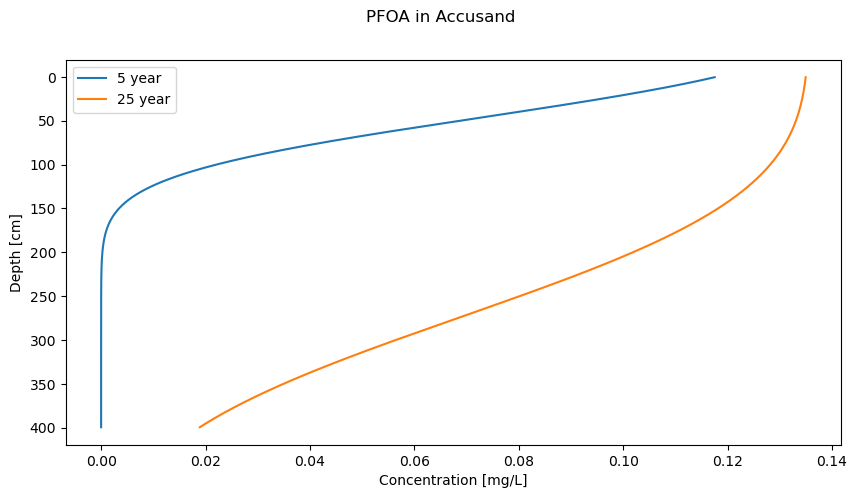

In [16]:
plot_ts = pyfas.Q_(np.array([5., 25.]), "year")


fig, ax = plt.subplots(figsize=(10, 5))

for t in plot_ts:
    # Because the time steps are not exactly at integer years, we need to find the closest time step
    ix = np.abs(ts - t).argmin()
    plt.plot((result.C_total[:,ix]*pfoa.M).m_as("mg/L"), zs.m_as("cm"), label=ts[ix].__format__(".0f"))

ax.legend()
ax.invert_yaxis()
ax.set_xlabel("Concentration [mg/L]")
ax.set_ylabel("Depth [cm]")
fig.suptitle(sim.name)


We can also plot the sorbed concentration over time at different depths, by adding the `result.C_s` and `result.C_aw` variables and then plotting against the `ts`:

Text(0.5, 0.98, 'PFOA in Accusand')

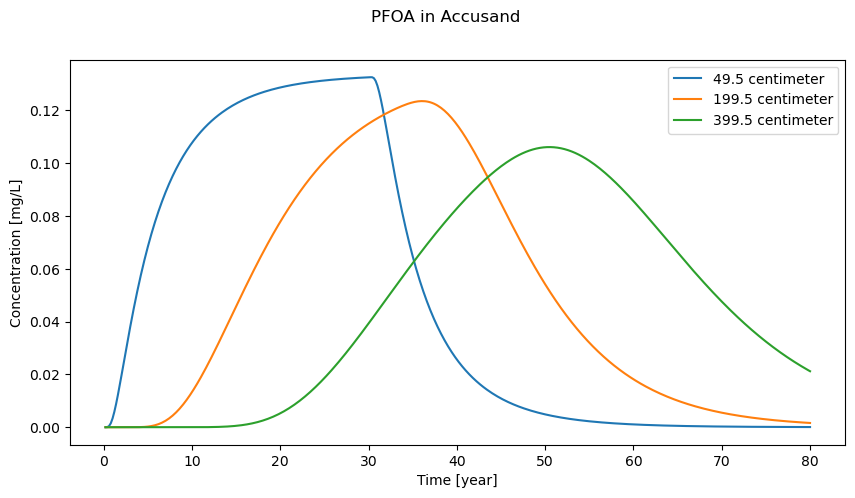

In [17]:
plot_depths = pyfas.Q_(np.array([0.5, 2., 4.]), "m")

fig, ax = plt.subplots(figsize=(10, 5))

for z in plot_depths:
    # Because the depths are not exactly at integer meters, we need to find the closest depth
    ix = np.abs(zs - z).argmin()
    plt.plot(sim.ts.m_as("year"), ((result.C_s[ix,:]+result.C_aw[ix,:])*pfoa.M).m_as("mg/L"), label=zs[ix].__format__(".1f"))

ax.legend()
ax.set_xlabel("Time [year]")
ax.set_ylabel("Concentration [mg/L]")

fig.suptitle(sim.name)
